In [1]:
#!pip install SPARQLWrapper
#!pip install pandas
#!pip install numpy
#!pip install matplotlib
#!pip install seaborn
#!pip install sparqlwrapper
#!pip install plotly

In [2]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import seaborn as sns
from SPARQLWrapper import SPARQLWrapper, N3, JSON
from rdflib import Graph

import plotly.express as px


%matplotlib inline

In [3]:
#endpoint = "http://localhost:9999/blazegraph/sparql" # SPARQL endpoint hosting ITO.owl

endpoint = "http://149.148.106.153:9999/blazegraph/sparql"
prefixes = """
PREFIX edam: <http://edamontology.org/>
PREFIX obo:  <http://purl.obolibrary.org/obo/>
PREFIX ito:  <https://identifiers.org/ito#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX foaf: <http://xmlns.com/foaf/0.1/>
"""

def query(service, query, numeric_cols = []):
    """
    Helper function to convert SPARQL results into a Pandas data frame.
    """
    sparql = SPARQLWrapper(service)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    result = sparql.query()

    processed_results = json.load(result.response)
    cols = processed_results['head']['vars']

    out = []
    for row in processed_results['results']['bindings']:
        item = []
        for c in cols:
            item.append(row.get(c, {}).get('value'))
        out.append(item)
        
    df = pd.DataFrame(out, columns=cols)
    for col in numeric_cols:
        df[col] = pd.to_numeric(df[col])
    
    return df


In [22]:
#Query database

desired_measure = "Hits-at-10"
desired_benchmark= "WN18RR"

#desired_benchmark= "FB15k"

#desired_benchmark= "Citeseer"   #this benchmark has zero results for "Hits-at-10"

#desired_benchmark= "FB15k-237"
#desired_measure = "MRR"


query = """
PREFIX edam: <http://edamontology.org/>
PREFIX obo:  <http://purl.obolibrary.org/obo/>
PREFIX ito:  <https://identifiers.org/ito:>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX foaf: <http://xmlns.com/foaf/0.1/>
     
SELECT *
WHERE {
    ?paper a edam:data_0971 . 
    ?paper rdfs:label ?paperTitle. 
    ?paper obo:date ?date. 

  	?benchmark_process_individual 	rdfs:seeAlso ?paper ;
									rdfs:label ?model_label ;
                                    a ?benchmark_process_class . # this will create a place holder for the rdfs:type results that contains the information about the individual
  	?benchmark_process_class rdfs:label ?benchmark_process_class_label .
    
 
    ?performance_measure rdfs:subPropertyOf* ito:performance_measure .
    ?performance_measure rdfs:label ?metricName .
    
    
  
    ?performance_measure rdfs:label ?metricName .
    ?benchmark_process_individual ?performance_measure ?result .	
  
   
	#FILTER regex(?paperTitle, "Quaternion Knowledge Graph Embeddings" ). # this searches a specific match
    FILTER regex(?metricName, "^"""+ desired_measure +"""$" ). # this searches a specific match
    FILTER regex(?benchmark_process_class_label, "^"""+desired_benchmark+""" - Link Prediction benchmarking$" ). # this searches a specific match
    #FILTER regex(?benchmark_process_class_label, "^FB15k - Link Prediction benchmarking" ). # this searches a specific match
    
    #WN18RR - Link Prediction benchmarking
  
  
  
    
} ORDER by ?date


 
"""

#send query via API
sparql = SPARQLWrapper(endpoint)
sparql.setQuery(query)
sparql.setReturnFormat(JSON)
result = sparql.query()

#process results as JSON
processed_results = json.load(result.response)

#Use accessory function to process results
cols = processed_results['head']['vars']

out = []
for row in processed_results['results']['bindings']:
    item = []
    for c in cols:
        item.append(row.get(c, {}).get('value'))
    
    out.append(item)
        
df = pd.DataFrame(out, columns=cols)

#Set date column to datetime
df['date'] = pd.to_datetime(df['date'])

#Keep only the model name
df.new = df.replace(to_replace =' model in .*$', value = '', regex = True)

df.new["result"] = pd.to_numeric(df.new["result"]) 

#Create dataframe to store state of art results
sota = pd.DataFrame(columns = df.new.columns)

best_value = 0
i=0

for result in df.new["result"]:        
        if result > best_value:
            best_value = result
            sota_add = pd.DataFrame(df.new.iloc[i]).transpose()
            sota = sota.append(sota_add)            
        i = i+1    

#This variable is containing the data points to plot the state of the art line        
#sota




<ipython-input-22-0b05700bb8e3>:84: UserWarning:

Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access



In [23]:
if len(df.index)==0 :
    print("Zero")
else:
    print("Results: ",len(df.index))     

Results:  28


In [24]:
df

,paper,paperTitle,date,benchmark_process_individual,model_label,benchmark_process_class,benchmark_process_class_label,performance_measure,metricName,result
0,https://identifiers.org/ito:ITO_02749,Translating Embeddings for Modeling Multi-rela...,2013-12-01,https://identifiers.org/ito:ito_0279114,TransE model in 'Translating Embeddings for Mo...,https://identifiers.org/ito:ITO_02791,WN18RR - Link Prediction benchmarking,https://identifiers.org/ito:ITO_02605,Hits-at-10,0.5555
1,https://identifiers.org/ito:ITO_02638,Convolutional 2D Knowledge Graph Embeddings,2017-07-05,https://identifiers.org/ito:ito_0279123,ConvE model in 'Convolutional 2D Knowledge Gra...,https://identifiers.org/ito:ITO_02791,WN18RR - Link Prediction benchmarking,https://identifiers.org/ito:ITO_02605,Hits-at-10,0.52
2,https://identifiers.org/ito:ITO_02638,Convolutional 2D Knowledge Graph Embeddings,2017-07-05,https://identifiers.org/ito:ito_0279128,Inverse Model model in 'Convolutional 2D Knowl...,https://identifiers.org/ito:ITO_02791,WN18RR - Link Prediction benchmarking,https://identifiers.org/ito:ITO_02605,Hits-at-10,0.35
3,https://identifiers.org/ito:ITO_02664,KBGAN: Adversarial Learning for Knowledge Grap...,2017-11-11,https://identifiers.org/ito:ito_0279126,KBGAN (TransD + ComplEx) model in 'KBGAN: Adve...,https://identifiers.org/ito:ITO_02791,WN18RR - Link Prediction benchmarking,https://identifiers.org/ito:ITO_02605,Hits-at-10,0.469
4,https://identifiers.org/ito:ITO_02796,A Novel Embedding Model for Knowledge Base Com...,2017-12-06,https://identifiers.org/ito:ito_0279120,ConvKB model in 'A Novel Embedding Model for K...,https://identifiers.org/ito:ITO_02791,WN18RR - Link Prediction benchmarking,https://identifiers.org/ito:ITO_02605,Hits-at-10,0.525
5,https://identifiers.org/ito:ITO_02642,Canonical Tensor Decomposition for Knowledge B...,2018-06-19,https://identifiers.org/ito:ito_0279110,ComplEx-N3 (reciprocal) model in 'Canonical Te...,https://identifiers.org/ito:ITO_02791,WN18RR - Link Prediction benchmarking,https://identifiers.org/ito:ITO_02605,Hits-at-10,0.57
6,https://identifiers.org/ito:ITO_02650,Hypernetwork Knowledge Graph Embeddings,2018-08-21,https://identifiers.org/ito:ito_0279122,HypER model in 'Hypernetwork Knowledge Graph E...,https://identifiers.org/ito:ITO_02791,WN18RR - Link Prediction benchmarking,https://identifiers.org/ito:ITO_02605,Hits-at-10,0.522
7,https://identifiers.org/ito:ITO_02793,Predicting Semantic Relations using Global Gra...,2018-08-27,https://identifiers.org/ito:ito_027912,M3GM model in 'Predicting Semantic Relations u...,https://identifiers.org/ito:ITO_02791,WN18RR - Link Prediction benchmarking,https://identifiers.org/ito:ITO_02605,Hits-at-10,0.5902
8,https://identifiers.org/ito:ITO_02697,End-to-end Structure-Aware Convolutional Netwo...,2018-11-11,https://identifiers.org/ito:ito_0279116,Structure-Aware Convolutional Networks model i...,https://identifiers.org/ito:ITO_02791,WN18RR - Link Prediction benchmarking,https://identifiers.org/ito:ITO_02605,Hits-at-10,0.54
9,https://identifiers.org/ito:ITO_02671,NSCaching: Simple and Efficient Negative Sampl...,2018-12-16,https://identifiers.org/ito:ito_0279125,ComplEx NSCaching model in 'NSCaching: Simple ...,https://identifiers.org/ito:ITO_02791,WN18RR - Link Prediction benchmarking,https://identifiers.org/ito:ITO_02605,Hits-at-10,0.5089


In [25]:

#Now finally plot the graph
#REF: https://plotly.com/python/line-charts/

import plotly.graph_objects as go
import numpy as np

#this is a copy to use as hovertemplate below
y=df.new["result"].astype(str)

# Create traces
fig = go.Figure()

fig.add_trace(go.Scatter(x=df.new["date"], y=df.new["result"], 
                         mode='markers', name='models',
                         hovertemplate=df.new["model_label"]+": "+ y)
             )

fig.add_trace(go.Scatter(x=sota["date"], y=sota["result"], 
                         mode='lines', name='state of the art',
                         hovertemplate=sota["model_label"]+": "+ y)
                          
             )


fig.update_yaxes(categoryorder="category ascending")

title_str = df.new.benchmark_process_class_label.unique()[0]
y_label = df.new.metricName.unique()[0]

fig.update_layout(
    title=title_str,
    xaxis_title="Year",
    yaxis_title=y_label,
    legend_title="Legend",
    font=dict(
        family="Arial",
        size=12,
        color="Black"
    )
)


fig.show()



In [8]:
ratio_df = pd.DataFrame(columns = ["ds_count", "ds", "date", "model_label","metricName","value","gain","ratio","total"])

In [9]:
#This block collects the rate of the benchmarkings along the years and saves it
#ratio_df = pd.DataFrame(columns = ["ds_count", "ds", "date", "value","gain","ratio","total"])

#len(sota["result"])
max(sota["result"])
min(sota["result"])

ds_count = 1

i=0
for res in sota["result"]:
    if sota.loc[sota.index[i], 'result'] <= max(sota["result"]) :
        if(i == 0):
            gain = sota.loc[sota.index[i], 'result']
        else :
            gain = round(sota.loc[sota.index[i], 'result'] - sota.loc[sota.index[i-1], 'result'],2)
            
        total = round( gain / max(sota["result"]) ,2)
        #total = round((sota.loc[sota.index[i+1], 'result'] - sota.loc[sota.index[i], 'result'] ),2)
        #print(sota["result"][i+1] - sota["result"][i])
        #OK print(total.astype(str)+ " : " + max(sota["result"]).astype(str) )
        
        #year=sota.loc[sota.index[i], 'date'].strftime('%Y-%m-%d')
        year=sota.loc[sota.index[i], 'date'].strftime('%Y-%m')
        model_label=sota.loc[sota.index[i], 'model_label']
        metricName=sota.loc[sota.index[i], 'metricName']
        value=sota.loc[sota.index[i], 'result'].astype(str)
        
        benchmarking=sota.loc[sota.index[i], 'benchmark_process_class_label']
        #benchmarking = df.replace(to_replace =' model in .*$', value = '', regex = True)
        import re
        
        benchmarking = re.sub(r'\-.*',"",benchmarking) 
        #re.sub(r'\.\.\..*',"",test)
        
        new_row = {'ds_count':ds_count, 'ds':benchmarking, 'date':year,'model_label':model_label,'metricName':metricName,'value':value, 'gain':gain.astype(str), 'ratio':total.astype(str), 'total':max(sota["result"]).astype(str)}
        ratio_df = ratio_df.append(new_row, ignore_index=True)
        
        print("Ds: " + benchmarking +
              "\t date: " + year +
              "\t model_label: " + model_label +
              "\t metricName:" + metricName + 
              "\t value:" + value + 
              "\t gain : " + gain.astype(str) + 
              "\t ratio: " + total.astype(str) + 
              "\t total: " + max(sota["result"]).astype(str) )
        
        
        i = i+1
        
        
    

Ds: WN18RR 	 date: 2013-12	 model_label: TransE	 metricName:Hits-at-10	 value:0.5555	 gain : 0.5555	 ratio: 0.92	 total: 0.604
Ds: WN18RR 	 date: 2018-06	 model_label: ComplEx-N3 (reciprocal)	 metricName:Hits-at-10	 value:0.57	 gain : 0.01	 ratio: 0.02	 total: 0.604
Ds: WN18RR 	 date: 2018-08	 model_label: M3GM	 metricName:Hits-at-10	 value:0.5902	 gain : 0.02	 ratio: 0.03	 total: 0.604
Ds: WN18RR 	 date: 2019-12	 model_label: GAATs	 metricName:Hits-at-10	 value:0.604	 gain : 0.01	 ratio: 0.02	 total: 0.604


In [10]:
ratio_df

,ds_count,ds,date,model_label,metricName,value,gain,ratio,total
0,1,WN18RR,2013-12,TransE,Hits-at-10,0.5555,0.5555,0.92,0.604
1,1,WN18RR,2018-06,ComplEx-N3 (reciprocal),Hits-at-10,0.57,0.01,0.02,0.604
2,1,WN18RR,2018-08,M3GM,Hits-at-10,0.5902,0.02,0.03,0.604
3,1,WN18RR,2019-12,GAATs,Hits-at-10,0.604,0.01,0.02,0.604


In [11]:
ratio_df["percent"] = round(ratio_df["value"].astype(float)/ratio_df["total"].astype(float),2)*100
ratio_df

,ds_count,ds,date,model_label,metricName,value,gain,ratio,total,percent
0,1,WN18RR,2013-12,TransE,Hits-at-10,0.5555,0.5555,0.92,0.604,92.0
1,1,WN18RR,2018-06,ComplEx-N3 (reciprocal),Hits-at-10,0.57,0.01,0.02,0.604,94.0
2,1,WN18RR,2018-08,M3GM,Hits-at-10,0.5902,0.02,0.03,0.604,98.0
3,1,WN18RR,2019-12,GAATs,Hits-at-10,0.604,0.01,0.02,0.604,100.0


In [12]:
fig = go.Figure()



# markers 1
fig.add_trace(go.Scatter(x=ratio_df["date"], 
                         y=ratio_df["ds"], 
                         #yaxis = ratio_df.iloc[0]["ds"],
                         name=ratio_df.iloc[0]["ds"],
                         
                         mode = 'markers + lines',
                         marker=dict(color=ratio_df["percent"].astype("float"),
                                     colorscale='oranges', 
                                     colorbar=dict(title='% of max.:<BR>'+ desired_measure)),
                         marker_size=ratio_df["percent"].astype("float")/10,
#                         hovertemplate=ratio_df["model_label"]+": "+ ratio_df["gain"],
                         
                         
                         hovertemplate="<BR>Ds: "+ ratio_df["ds"]+
                                              "<BR>Model_label: "+ ratio_df["model_label"]+
                                              "<BR>metricName: "+ ratio_df["metricName"]+
                                              "<BR>value: "+ ratio_df["value"]+
                                              "<BR>Max. value: "+ max(ratio_df["total"])+
                                              "<BR>% of max. value: "+round(((ratio_df["value"].astype("float")/max(ratio_df["total"].astype(float)))*100),3).astype("string")+"%", 
                         
                         
                         showlegend=True
                         ),
             )


fig.update_layout(legend=dict(x=-.15, y=1))
fig.update_traces(marker_line_width=2, marker_line_color="black")
fig.show()

In [13]:
ratio_df

,ds_count,ds,date,model_label,metricName,value,gain,ratio,total,percent
0,1,WN18RR,2013-12,TransE,Hits-at-10,0.5555,0.5555,0.92,0.604,92.0
1,1,WN18RR,2018-06,ComplEx-N3 (reciprocal),Hits-at-10,0.57,0.01,0.02,0.604,94.0
2,1,WN18RR,2018-08,M3GM,Hits-at-10,0.5902,0.02,0.03,0.604,98.0
3,1,WN18RR,2019-12,GAATs,Hits-at-10,0.604,0.01,0.02,0.604,100.0


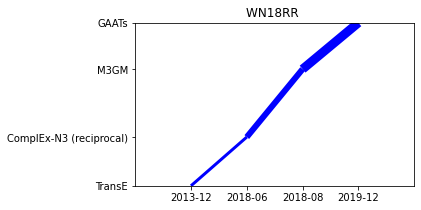

In [14]:
import numpy as np
from matplotlib.collections import LineCollection
import matplotlib.pyplot as plt

y = ratio_df["value"].astype(float)
x=ratio_df.index.values

lwidths=((x+1)*3)

#lwidths

points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

#segments

lc = LineCollection(segments, linewidths=lwidths,color='blue')

fig,a = plt.subplots(figsize=(5,3))
a.add_collection(lc)
a.set_ylim(0,1)
a.set_xlim(-1,max(ratio_df.index.values)+1)
a.set_xticks(x)
a.set_xticklabels([i for i in ratio_df["date"]])
a.set_yticks(y)
a.set_yticklabels([i for i in ratio_df["model_label"]])
a.set_ylim(min(y),max(y))
a.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False)
a.title.set_text(ratio_df["ds"][0])




#Reference:
#https://stackoverflow.com/questions/19390895/matplotlib-plot-with-variable-line-width

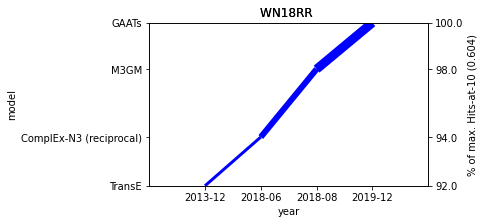

In [15]:
#Plot with ylabels on both sides

# import libraries
import numpy as np
import matplotlib.pyplot as plt


y = ratio_df["value"].astype(float)
x=ratio_df.index.values

lwidths=((x+1)*3)

#lwidths

points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

#segments

lc = LineCollection(segments, linewidths=lwidths,color='blue')

# Creating dataset
# Creating plot with dataset_1
#fig, ax1 = plt.subplots()


fig,a = plt.subplots(figsize=(5,3))
a.add_collection(lc)
a.set_ylim(0,1)
a.set_xlim(-1,max(ratio_df.index.values)+1)
a.set_xticks(x)
a.set_xticklabels([i for i in ratio_df["date"]])
a.set_yticks(y)
a.set_yticklabels([i for i in ratio_df["model_label"]])
a.set_ylim(min(y),max(y))
#a.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False)
a.title.set_text(ratio_df["ds"][0])
a.set_xlabel("year")
a.set_ylabel("model")

# Adding Twin Axes to plot using dataset_2
a2 = a.twinx()
a2.set_yticks(y)
a2.set_yticklabels([i for i in ratio_df["percent"]])
a2.set_ylim(min(y),max(y))
#a.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False)
a2.title.set_text(ratio_df["ds"][0])
a2.set_ylabel("% of max. "+ratio_df["metricName"][0]+" ("+ratio_df["total"][0]+")")


# Adding title


# Show plot
plt.show()


In [16]:
ratio_df

,ds_count,ds,date,model_label,metricName,value,gain,ratio,total,percent
0,1,WN18RR,2013-12,TransE,Hits-at-10,0.5555,0.5555,0.92,0.604,92.0
1,1,WN18RR,2018-06,ComplEx-N3 (reciprocal),Hits-at-10,0.57,0.01,0.02,0.604,94.0
2,1,WN18RR,2018-08,M3GM,Hits-at-10,0.5902,0.02,0.03,0.604,98.0
3,1,WN18RR,2019-12,GAATs,Hits-at-10,0.604,0.01,0.02,0.604,100.0


<ipython-input-17-48947b2b555a>:36: UserWarning:

Attempting to set identical bottom == top == 1 results in singular transformations; automatically expanding.

<ipython-input-17-48947b2b555a>:52: UserWarning:

Attempting to set identical bottom == top == 1 results in singular transformations; automatically expanding.



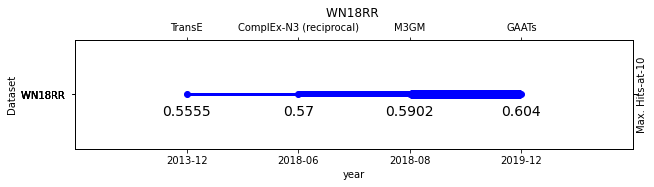

In [17]:
#Plot with ylabels on both sides

# import libraries
import numpy as np
import matplotlib.pyplot as plt


y = ratio_df["ds_count"]
x=ratio_df.index.values

lwidths=((x+1)*3)

#lwidths

points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

#segments

lc = LineCollection(segments, linewidths=lwidths,color='blue')

# Creating dataset
# Creating plot with dataset_1
#fig, ax1 = plt.subplots()


fig,a = plt.subplots(figsize=(10,2))
a.add_collection(lc)
a.set_xlim(-1,max(ratio_df.index.values)+1)
a.set_xticks(x)
a.set_xticklabels([i for i in ratio_df["date"]])

a.set_ylim(0,1)
a.set_yticks(y)
a.set_yticklabels(ratio_df["ds"])
a.set_ylim(min(y),max(y))
#a.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False)
a.title.set_text(ratio_df["ds"][0])
a.set_xlabel("year")
a.set_ylabel("Dataset")

    
# Adding Twin Axes to plot y left
a2 = a.twinx()

a2.set_xlim(-1,max(ratio_df.index.values)+1)
a2.set_xticks(x)
a2.set_xticklabels([i for i in ratio_df["date"]])

a2.set_yticks(y)
a2.set_yticklabels(ratio_df["total"])
a2.set_ylim(min(y),max(y))
#a.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False)
a2.set_ylabel("Max. "+ratio_df["metricName"][0])
a2.tick_params(labelbottom=True, labeltop=False, labelleft=False, labelright=False)

# Adding Twin Axes to plot x top
a3 = a.twiny()
a3.set_xlim(-1,max(ratio_df.index.values)+1)
a3.set_xticks(x)
a3.set_xticklabels([i for i in ratio_df["model_label"]])
a3.tick_params(labelbottom=False, labeltop=True, labelleft=False, labelright=False)


for i, txt in enumerate(ratio_df["value"]):
    a.annotate( txt, (x[i], y[i]),
                ha='center',
                va='top',
                xytext=(x[i],y[i]-0.01), #distace of the text from the point
                fontsize=14) 

#use this to annotate the line
a.scatter(x, y,  c = 'blue' ) #this adds the dots to the plot

     
# Show plot
plt.show()


In [18]:
ratio_df2 =  ratio_df.copy()
ratio_df2["ds"]="TEST"
ratio_df2["ds_count"]=2

ratio_df

,ds_count,ds,date,model_label,metricName,value,gain,ratio,total,percent
0,1,WN18RR,2013-12,TransE,Hits-at-10,0.5555,0.5555,0.92,0.604,92.0
1,1,WN18RR,2018-06,ComplEx-N3 (reciprocal),Hits-at-10,0.57,0.01,0.02,0.604,94.0
2,1,WN18RR,2018-08,M3GM,Hits-at-10,0.5902,0.02,0.03,0.604,98.0
3,1,WN18RR,2019-12,GAATs,Hits-at-10,0.604,0.01,0.02,0.604,100.0
